<a href="https://colab.research.google.com/github/AldaCL/Deep-Learning-Notes/blob/main/Clothes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# download training data
train_data = datasets.FashionMNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,

)

#download test_data
test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

In [ ]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [ ]:
# Define the size of the subset
subset_size = 100

# Create a list of indices for the subset
indices = list(range(subset_size))

# Create the subset of the dataset
subset = Subset(train_data, indices)


In [ ]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [ ]:
# Find unique targets
np.unique(train_data.targets, return_counts= True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

## Dataloader

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
# batch size 150 for train and twst
train_Dloader = DataLoader(dataset = subset,
                           batch_size = 150)

test_Dloader = DataLoader(dataset = test_data,
                          batch_size = 150)

In [ ]:
len(test_Dloader)

67

## Visualization

In [ ]:
labels = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

#Visualize function of label
def fashionShow(index):
  plt.imshow(train_data.data[index], cmap = "Greys")
  print(labels[train_data[index][1]])

Dress


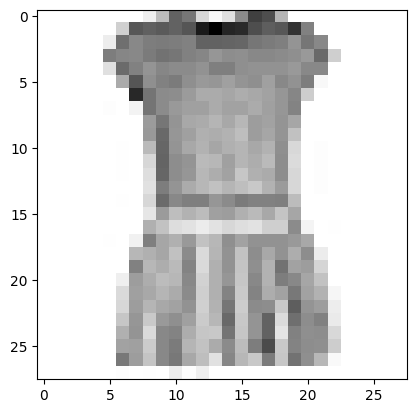

In [ ]:
fashionShow(3)

## CNN

In [ ]:
import torch
from torch import nn

In [ ]:
class fashionConvNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels = 1,
                  out_channels = 32,
                  kernel_size = 2,
                  padding = 'same'),
        nn.BatchNorm2d(num_features = 32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels = 32,
                  out_channels = 64,
                  kernel_size = 5),
        nn.BatchNorm2d(num_features = 64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    self.flatten = nn.Flatten()

    self.fc1 = nn.Linear(
        in_features = 64*5*5,
        out_features = 512)
    self.drop1 = nn.Dropout2d(p = 0.3)

    self.fc2 = nn.Linear(
        in_features = 512,
        out_features = 128)
    self.drop2 = nn.Dropout2d(p = 0.2)

    # batch normalization & output layer
    self.batchNorm = nn. BatchNorm1d (num_features = 128)
    self.fc3 = nn.Linear(
    in_features = 128,
    out_features = 10)

  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.flatten(out)

    out = self.fc1(out)
    out = self.drop1(out)
    out = self.fc2(out)
    out = self.drop2(out)
    out = self.batchNorm(out)
    out = self.fc3(out)

    return out


convModel = fashionConvNet()
print(convModel)

fashionConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (drop1): Dropout2d(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (drop2): Dropout2d(p=0.2, inplace=False)
  (batchNorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


## loss and optimizer

In [ ]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(
    convModel.parameters(),
    lr = 0.002
)

## Training Function

In [ ]:
def training_convnet(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset) # 60K, since we have 60K Train images

  # Sets the module in training mode
  model.train()

  for index, (image, label) in enumerate(dataloader):
    # Loss calculation
    pred = model(image)
    loss = loss_fn(pred, label) # Loss calculation

    # Backpropagation
    optimizer.zero_grad() # zero out gradients in each loop
    loss.backward()
    optimizer.step()

    # print loss and progrss of training
    if index % 100 == 0:
      loss = loss.item()
      current = index * len(image)
      print(f"loss: {loss:.3f})\
      progress: {(current / size)*100:.2f}%")

## testing function

In [ ]:
def testing_convnet(dataloader, model):
  size = len(dataloader.dataset)

  model.eval()

  correct = 0

  with torch.no_grad():
    for image, label in dataloader:
        pred = model(image)

        correct += (pred.argmax(1) == label).type(torch.float).sum().item()


  print(f"\n Test Accuracy: {(correct/size)*100:.2f}%")
  print(f"Calculate {(correct/size)}")
  return 5*round(((correct/size)*100)/5)

## training & evaluation

In [ ]:
keys_dict = np.arange(0, 100, 5)

In [ ]:
list_correct = dict((el,0) for el in keys_dict)

In [ ]:
epochs = 7
for _ in range(0,7):
  for e in range(epochs) :

    # print Epoch number
    print(f"\n\n Epoch {e+1} ---------- \n")

    # training
    training_convnet(train_Dloader, convModel, loss_fn, optimizer)


    print(f"\n\n Evaluate test ---------- \n")
    # evaluating at the end of each epoch
    correct_value = testing_convnet(test_Dloader, convModel)
    print(f"Correct value {correct_value}")
  list_correct[correct_value] += 1



 Epoch 1 ---------- 



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


loss: 2.371)      progress: 0.00%


 Evaluate test ---------- 


 Test Accuracy: 22.36%
Calculate 0.2236
Correct value 20


 Epoch 2 ---------- 

loss: 1.063)      progress: 0.00%


 Evaluate test ---------- 


 Test Accuracy: 37.85%
Calculate 0.3785
Correct value 40


 Epoch 3 ---------- 

loss: 0.816)      progress: 0.00%


 Evaluate test ---------- 


 Test Accuracy: 46.11%
Calculate 0.4611
Correct value 45


 Epoch 4 ---------- 

loss: 0.668)      progress: 0.00%


 Evaluate test ---------- 


 Test Accuracy: 47.30%
Calculate 0.473
Correct value 45


 Epoch 5 ---------- 

loss: 0.524)      progress: 0.00%


 Evaluate test ---------- 


 Test Accuracy: 46.54%
Calculate 0.4654
Correct value 45


 Epoch 6 ---------- 

loss: 0.445)      progress: 0.00%


 Evaluate test ---------- 


 Test Accuracy: 40.93%
Calculate 0.4093
Correct value 40


 Epoch 7 ---------- 

loss: 0.362)      progress: 0.00%


 Evaluate test ---------- 


 Test Accuracy: 33.74%
Calculate 0.3374
Correct value 35


 

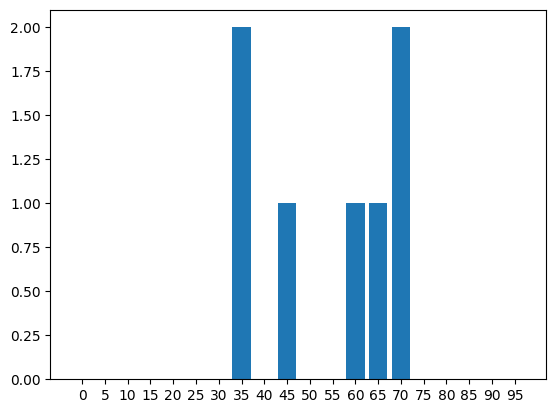

In [ ]:
import matplotlib.pyplot as plt


plt.bar(range(len(list_correct)), list(list_correct.values()), align='center')
plt.xticks(range(len(list_correct)), list(list_correct.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x

plt.show()

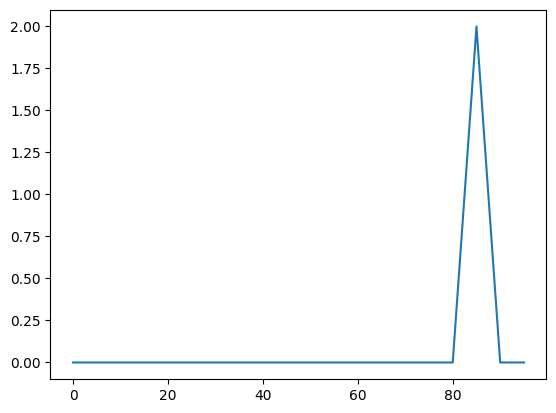

In [ ]:
import matplotlib.pylab as plt

lists = sorted(list_correct.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

In [ ]:
n = [10, 50, 100, 200, 400]

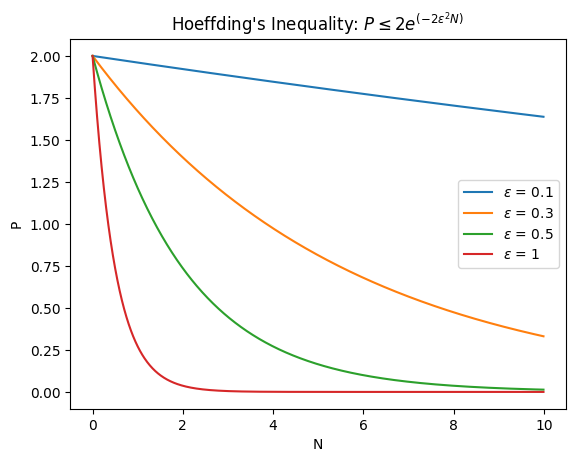

In [ ]:
#
# Draw the Hoeffding's Inequality with different epsilons, 0.1, 0.3, 0.5, and 1.
#

from scipy import signal
import numpy as np
import math

def hoeffding (x, epsilon):
	y = 2.0 * math.exp (-2*epsilon*epsilon*x)
	return y

#x = np.arange (0, 100, 0.01)
x = np.arange (0, 10, 0.01)

y1 = [hoeffding (x, 0.1) for x in x]
y2 = [hoeffding (x, 0.3) for x in x]
y3 = [hoeffding (x, 0.5) for x in x]
y4 = [hoeffding (x, 1) for x in x]

import matplotlib.pyplot as plt

plt.xlabel ('N')
plt.ylabel ('P')
latex1 = r'P\leq2e^{\left( -2\varepsilon ^{2}N\right)}'
plt.title (r"Hoeffding's Inequality: $ %s $" % latex1)

latext2 = r'\varepsilon'
plt.plot (x, y1, label=r'$%s$ = 0.1' % latext2)
plt.plot (x, y2, label='$%s$ = 0.3' % latext2)
plt.plot (x, y3, label='$%s$ = 0.5' % latext2)
plt.plot (x, y4, label='$%s$ = 1' % latext2)

plt.legend ()
plt.show ()

In [ ]:
from scipy import signal
import numpy as np
import math

epsilon = 0.5

y = 2.0 * math.exp (-2*epsilon*epsilon*x)